In [ ]:
pip install kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 20.2 MB/s eta 0:00:00


In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.2 MB/s eta 0:00:00


In [ ]:
import optuna
import numpy as np
import pandas as pd
from sklearn.metrics import  mean_absolute_error
from sklearn.preprocessing import  MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l1, l2, L1L2


import random


In [ ]:
# Grant access to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read the csv file
df = pd.read_csv('/content/drive/MyDrive/00_GITHUB_GD/04_SPIONS_GD/ADV_09/00_SPIONS_data_V11_ADV_09.csv', sep=',', encoding='latin1')

# to remove the unnecessary columns
filtered_columns = [col for col in df.columns if col.startswith('f_')]
df_01 = df[filtered_columns]

In [ ]:
# Name of the model
model_name = "NN_ADV_09_V500K_V02"
# Number of trials
trial_number_n = 100


In [ ]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
# defining columns
selected_columns = ['f_volume_core_estimated_nm3', 'f_area_core_estimated_nm2',
       'f_area_volume_ratio', 'f_ratio_Zn_Fe', 'f_ratio_Co_Fe',
       'f_ratio_Mn_Fe', 'f_ratio_Mg_Fe', 'f_conc_MNP_mg_mL',
       'f_avg_core_width_nm_BOTH','f_avg_core_sd_nm_BOTH', 'f_SAR_W_g_MNP_core_BOTH','f_H_Oe_BOTH', 'f_FCY_kHz_BOTH',
       'f_Ms_emu_g_MNP_BOTH', 'f_Mr_emu_g_MNP_BOTH',
       'f_Mr_Ms_BOTH', 'f_Hc_Oe_BOTH',
       'f_Tem_mp_K_BOTH','f_coated', 'f_organic', 'f_inorganic', 'f_water_soluble', 'f_oil_soluble',
       'f_composite_coating', 'f_free_to_rotate']
df_feat = df_01[selected_columns]
df_feat = df_feat.dropna(axis=0)
# Assign the data to X and y
X = df_feat.drop(['f_SAR_W_g_MNP_core_BOTH'], axis=1)
y = df_feat['f_SAR_W_g_MNP_core_BOTH']

In [ ]:
# Convert the target variable into quantile bins for stratification
# set the number of bins (bin_n)
bin_n = 20
y_bins = pd.qcut(y, q=bin_n, labels=False, duplicates='drop')

# First split: Split into train_cal_2_1 and test sets
X_train_cal_2_1, X_test, y_train_cal_2_1, y_test = train_test_split(X, y, test_size=232, random_state=1, stratify=y_bins)

# Update y_bins for the next split based on the remaining y_train_cal_2_1
y_bins_train_cal_2_1 = pd.qcut(y_train_cal_2_1, q=bin_n, labels=False, duplicates='drop')

# Second split: Split train_cal_2_1 into train_cal and val
X_train_cal, X_val, y_train_cal, y_val = train_test_split(X_train_cal_2_1, y_train_cal_2_1, test_size=232, random_state=1, stratify=y_bins_train_cal_2_1)

# Update y_bins for the next split based on the remaining y_train_cal
y_bins_train_cal = pd.qcut(y_train_cal, q=bin_n, labels=False, duplicates='drop')

# Third split: Split train_cal into train and cal
X_train, X_cal, y_train, y_cal = train_test_split(X_train_cal, y_train_cal, test_size=232, random_state=1, stratify=y_bins_train_cal)

In [ ]:
# Normalize the data. Fit on X_train_scaled_MnMx to avoid data leakage
scaler01 = MinMaxScaler(feature_range=(0,1))
scaler01.fit(X_train)
X_train_scaled_MnMx = scaler01.transform(X_train)
X_test_scaled_MnMx = scaler01.transform(X_test)
X_val_scaled_MnMx = scaler01.transform(X_val)
X_cal_scaled_MnMx = scaler01.transform(X_cal)

In [ ]:
path_to_save = '/content/drive/MyDrive/00_GITHUB_GD/04_SPIONS_GD/ADV_09/12_NN/V_02/'

In [ ]:
def objective(trial):
    # Hyperparameters to be optimized
    batch_size = trial.suggest_int('batch_size', 16, 256)
    epochs_n = trial.suggest_int('epochs', 200, 200)
    n_layers = trial.suggest_int('n_layers', 1, 5)
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.1, 0.2, 0.3, 0.4, 0.5])
    l1_reg = trial.suggest_float('l1_reg', 1e-5, 1e-1, log=True)  # L1 regularization hyperparameter
    l2_reg = trial.suggest_float('l2_reg', 1e-5, 1e-1, log=True)  # L2 regularization hyperparameter

    # Neural Network Architecture
    model = Sequential()
    for i in range(n_layers):
        num_neurons = trial.suggest_int(f'n_neurons_l{i}', 4, 512)
        if i == 0:
            model.add(Dense(num_neurons, input_shape=(X_train_scaled_MnMx.shape[1],)))
        else:
            model.add(Dense(num_neurons))
        model.add(BatchNormalization())  # Add BatchNormalization layer
        model.add(Activation('relu'))  # Move activation function after batch normalization
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_regularizer=L1L2(l1=l1_reg, l2=l2_reg)))  # Adding L1 and L2 regularization to the output layer

    # Compile the model
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')

    # Train the model on the training data
    model.fit(X_train_scaled_MnMx, y_train, batch_size=batch_size, epochs=epochs_n, verbose=0)

    # Predict on the training data
    y_train_pred = model.predict(X_train_scaled_MnMx, verbose=0)
    # Calculate MAE on the training data
    mae_score_train = mean_absolute_error(y_train, y_train_pred)

    # Predict on the validation data
    y_pred = model.predict(X_val_scaled_MnMx, verbose=0)
    # Calculate MAE on the validation data
    mae_score_val = mean_absolute_error(y_val, y_pred)

    # Set user attributes for training and validation MAE
    trial.set_user_attr("MAE_train", mae_score_train)
    trial.set_user_attr("MAE_val", mae_score_val)

    # Return the validation MAE for optimization
    return mae_score_val


In [ ]:
# Set a seed for reproducibility
sampler_seed_value = optuna.samplers.TPESampler(seed=10)
# Optimization with Optuna with early stopping callback
study = optuna.create_study(direction='minimize', sampler=sampler_seed_value)
study.optimize(objective, n_trials=trial_number_n)

# Best Hyperparameters
print("Best hyperparameters: ", study.best_params)

[I 2024-04-08 13:26:58,983] A new study created in memory with name: no-name-ef14c1ff-72c0-4799-bab4-1aa75499ad19
[I 2024-04-08 13:27:08,754] Trial 0 finished with value: 121.21955526002058 and parameters: {'batch_size': 201, 'epochs': 200, 'n_layers': 1, 'dropout_rate': 0.2, 'l1_reg': 0.011018509458263562, 'l2_reg': 4.7472635881072903e-05, 'n_neurons_l0': 48, 'learning_rate': 0.005513651007120869}. Best is trial 0 with value: 121.21955526002058.
[I 2024-04-08 13:27:13,967] Trial 1 finished with value: 214.94191124522382 and parameters: {'batch_size': 245, 'epochs': 200, 'n_layers': 1, 'dropout_rate': 0.2, 'l1_reg': 0.04689175530591104, 'l2_reg': 0.007216109813316294, 'n_neurons_l0': 280, 'learning_rate': 3.7040785712895284e-05}. Best is trial 0 with value: 121.21955526002058.
[I 2024-04-08 13:27:34,023] Trial 2 finished with value: 197.9154873043342 and parameters: {'batch_size': 105, 'epochs': 200, 'n_layers': 4, 'dropout_rate': 0.5, 'l1_reg': 0.0025360383322064173, 'l2_reg': 0.01663

Best hyperparameters:  {'batch_size': 156, 'epochs': 200, 'n_layers': 4, 'dropout_rate': 0.1, 'l1_reg': 1.9515128674247803e-05, 'l2_reg': 0.019658915895113326, 'n_neurons_l0': 126, 'n_neurons_l1': 256, 'n_neurons_l2': 387, 'n_neurons_l3': 329, 'learning_rate': 0.0016523078379859092}


In [ ]:
path_to_save = '/content/drive/MyDrive/00_GITHUB_GD/04_SPIONS_GD/ADV_09/12_NN/V_02/'

In [ ]:
# Name of the model
model_name = "NN_ADV_09_V500K_V2"

In [ ]:
# Collecting trial data
trials_data = []
for trial in study.trials:
    trial_dict = trial.params.copy()  # Copy hyperparameters
    trial_dict['trial_number'] = trial.number +1
    trial_dict['MAE_val'] = trial.value  # The objective was MAE (validation)
    # Retrieve training and validation MAE from user attributes
    trial_dict['MAE_train'] = trial.user_attrs.get("MAE_train", None)
    trial_dict['MAE_val'] = trial.user_attrs.get("MAE_val", None)
    trials_data.append(trial_dict)

# Converting to DataFrame
trials_df = pd.DataFrame(trials_data)
trials_df['Best_MAE_val'] = trials_df['MAE_val'].cummin()
trials_df['Best_MAE_train'] = trials_df['MAE_train'].cummin()
# Exporting to CSV
csv_file_name = f'{path_to_save}{model_name}_opt_his.csv'
trials_df.to_csv(csv_file_name, index=False)

print(f"Data saved to {csv_file_name}")

Data saved to /content/drive/MyDrive/00_GITHUB_GD/04_SPIONS_GD/ADV_09/12_NN/V_02/NN_ADV_09_V500K_V2_opt_his.csv


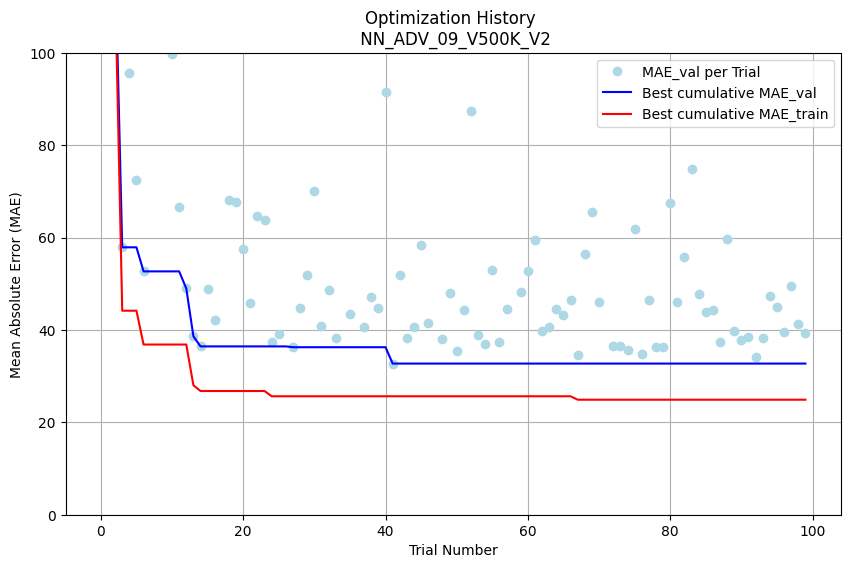

In [ ]:
# Load the optimization history
df = pd.read_csv(f'{path_to_save}{model_name}_opt_his.csv')

# Plotting the original MAE values
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['MAE_val'], marker='o', linestyle='', color='lightblue',label='MAE_val per Trial')

# Plotting the line that tracks the best (lowest) MAE value
plt.plot(df.index, df['Best_MAE_val'], marker='', linestyle='-', color='b', label='Best cumulative MAE_val')
plt.plot(df.index, df['Best_MAE_train'], marker='', linestyle='-', color='r', label='Best cumulative MAE_train')

plt.title(f'Optimization History \n {model_name}')
plt.xlabel('Trial Number')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend(loc='upper right')
plt.grid(True)
plt.ylim(0,100)
plt.show()

In [ ]:
# Best Hyperparameters
print("Best hyperparameters: ", study.best_params)

Best hyperparameters:  {'batch_size': 156, 'epochs': 200, 'n_layers': 4, 'dropout_rate': 0.1, 'l1_reg': 1.9515128674247803e-05, 'l2_reg': 0.019658915895113326, 'n_neurons_l0': 126, 'n_neurons_l1': 256, 'n_neurons_l2': 387, 'n_neurons_l3': 329, 'learning_rate': 0.0016523078379859092}


In [ ]:
# Extract hyperparameter importances
hyperparam_importances = optuna.importance.get_param_importances(study)

# Convert the hyperparameter importances to a DataFrame
importances_df = pd.DataFrame(list(hyperparam_importances.items()), columns=['Hyperparameter', 'Importance'])

# Sort the DataFrame by importance in descending order
importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Write the DataFrame to a CSV file
# Exporting to CSV
csv_file_path = f'{path_to_save}{model_name}_hyp_imp.csv'
try:
    importances_df.to_csv(csv_file_path, index=False)
    print(f"Data saved to {csv_file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

Data saved to /content/drive/MyDrive/00_GITHUB_GD/04_SPIONS_GD/ADV_09/12_NN/V_02/NN_ADV_09_V500K_V2_hyp_imp.csv


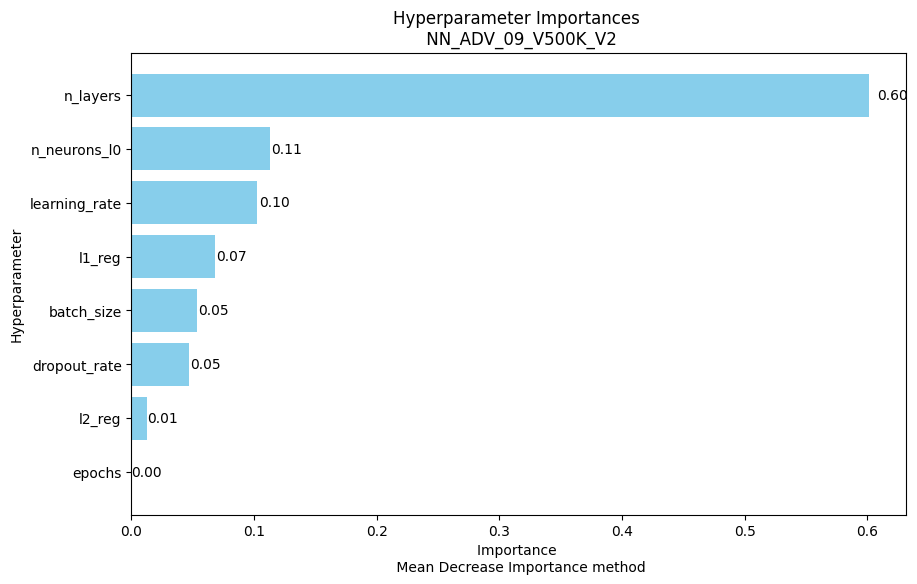

In [ ]:
csv_file_path = f'{path_to_save}{model_name}_hyp_imp.csv'

# Read the hyperparameter importances from the CSV file
importances_df = pd.read_csv(csv_file_path)

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(importances_df['Hyperparameter'], importances_df['Importance'], color='skyblue')
plt.xlabel('Importance \n Mean Decrease Importance method')
plt.ylabel('Hyperparameter')
plt.title(f'Hyperparameter Importances \n {model_name}')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
# Add the value of each bar to the plot
for bar in bars:
    width = bar.get_width()  # Get the width of the bar
    label_x_pos = width + bar.get_width() * 0.01  # Position the text slightly right of the bar
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

plt.show()

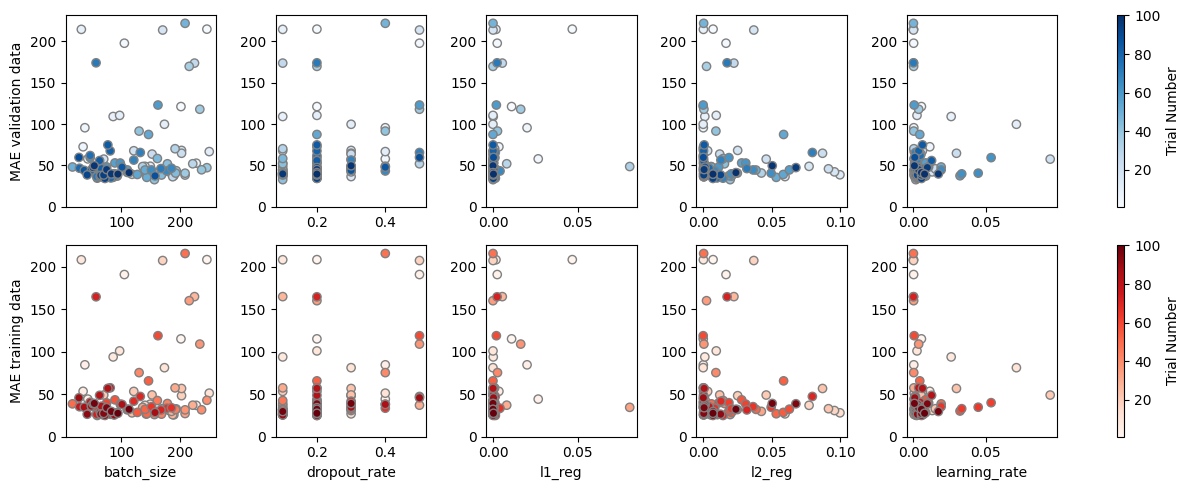

In [ ]:
df = pd.read_csv(f'{path_to_save}{model_name}_opt_his.csv')
NN_architecture = ['n_layers', 'n_neurons_l0', 'n_neurons_l1', 'n_neurons_l2', 'n_neurons_l3', 'n_neurons_l4']
df = df.drop(NN_architecture, axis=1)
df = df.drop(['epochs'],axis=1)

# Choose a blue colormap for the first row
cmap_n_blue = plt.get_cmap('Blues')

# Choose a red colormap for the second row
cmap_n_red = plt.get_cmap('Reds')

# Adjust the figsize here (width, height) in inches for better visibility
figsize_width = 12  # Adjust based on your actual number of columns and desired figure size
figsize_height = 5  # Height for 2 rows

# Create a figure to hold the subplots with the new figsize
fig = plt.figure(figsize=(figsize_width, figsize_height))

# GridSpec layout with space for colorbars
gs = fig.add_gridspec(2, 6, width_ratios=[1, 1, 1, 1, 1, 0.05], height_ratios=[1, 1])

# Creating subplots for each data plot
axs_data = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(5)]
# Creating subplots for colorbars
axs_cbar = [fig.add_subplot(gs[i, -1]) for i in range(2)]

# Plot each hyperparameter against MAE_val in the first row using the blue colormap
for i, col in enumerate(df.columns[:-5]):  # Adjust based on how many columns you want to plot
    if i < 5:  # Plot in the first 5 subplots of the first row
        sc_blue = axs_data[i].scatter(df[col], df['MAE_val'], c=df['trial_number'], cmap=cmap_n_blue, edgecolor='grey')
        #axs_data[i].set_xlabel(col)
        if i == 0:
            axs_data[i].set_ylabel('MAE validation data')
        axs_data[i].set_ylim(0)

# Plot each hyperparameter against MAE_train in the second row using the red colormap
for i, col in enumerate(df.columns[:-5]):  # Adjust based on how many columns you want to plot
    if i < 5:  # Plot in the first 5 subplots of the second row
        sc_red = axs_data[5 + i].scatter(df[col], df['MAE_train'], c=df['trial_number'], cmap=cmap_n_red, edgecolor='grey')
        axs_data[5 + i].set_xlabel(col)
        if i == 0:
            axs_data[5 + i].set_ylabel('MAE training data')
        axs_data[5 + i].set_ylim(0)

# Add a vertical colorbar to the last column of the first row
fig.colorbar(sc_blue, cax=axs_cbar[0], orientation='vertical').set_label('Trial Number')

# Add a vertical colorbar to the last column of the second row
fig.colorbar(sc_red, cax=axs_cbar[1], orientation='vertical').set_label('Trial Number')

plt.tight_layout()
plt.show()

In [ ]:
df = pd.read_csv(f'{path_to_save}{model_name}_opt_his.csv')
df = df.drop(['batch_size', 'dropout_rate', 'l1_reg', 'l2_reg', 'learning_rate', 'epochs'], axis=1)
df

,n_layers,n_neurons_l0,trial_number,MAE_val,MAE_train,n_neurons_l1,n_neurons_l2,n_neurons_l3,n_neurons_l4,Best_MAE_val,Best_MAE_train
0,1,48,1,121.219555,115.164890,NaN,NaN,NaN,NaN,121.219555,115.164890
1,1,280,2,214.941911,208.554564,NaN,NaN,NaN,NaN,121.219555,115.164890
2,4,269,3,197.915487,190.992619,466.0,166.0,50.0,NaN,121.219555,115.164890
3,5,388,4,57.880768,44.158127,154.0,453.0,169.0,87.0,57.880768,44.158127
4,5,308,5,95.574517,84.573449,463.0,276.0,304.0,23.0,57.880768,44.158127
...,...,...,...,...,...,...,...,...,...,...,...
95,4,250,96,44.940173,34.013323,142.0,392.0,89.0,NaN,32.716962,24.894835
96,4,332,97,39.658266,29.579750,68.0,400.0,139.0,NaN,32.716962,24.894835
97,4,265,98,49.549790,39.053482,112.0,311.0,422.0,NaN,32.716962,24.894835
98,5,180,99,41.233655,32.165495,218.0,423.0,220.0,85.0,32.716962,24.894835


In [ ]:
df = pd.read_csv(f'{path_to_save}{model_name}_opt_his.csv')

NN_architecture = ['n_layers', 'n_neurons_l0', 'n_neurons_l1', 'n_neurons_l2', 'n_neurons_l3', 'n_neurons_l4']

df_a = df[NN_architecture]
df_a



,n_layers,n_neurons_l0,n_neurons_l1,n_neurons_l2,n_neurons_l3,n_neurons_l4
0,1,48,NaN,NaN,NaN,NaN
1,1,280,NaN,NaN,NaN,NaN
2,4,269,466.0,166.0,50.0,NaN
3,5,388,154.0,453.0,169.0,87.0
4,5,308,463.0,276.0,304.0,23.0
...,...,...,...,...,...,...
95,4,250,142.0,392.0,89.0,NaN
96,4,332,68.0,400.0,139.0,NaN
97,4,265,112.0,311.0,422.0,NaN
98,5,180,218.0,423.0,220.0,85.0


In [ ]:
to_append = ['MAE_val',	'MAE_train', 'Best_MAE_val', 'Best_MAE_train']

df_b = df[to_append]
df_b

,MAE_val,MAE_train,Best_MAE_val,Best_MAE_train
0,121.219555,115.164890,121.219555,115.164890
1,214.941911,208.554564,121.219555,115.164890
2,197.915487,190.992619,121.219555,115.164890
3,57.880768,44.158127,57.880768,44.158127
4,95.574517,84.573449,57.880768,44.158127
...,...,...,...,...
95,44.940173,34.013323,32.716962,24.894835
96,39.658266,29.579750,32.716962,24.894835
97,49.549790,39.053482,32.716962,24.894835
98,41.233655,32.165495,32.716962,24.894835


In [ ]:
df_c = pd.concat([df_a, df_b], axis=1)
df_c

,n_layers,n_neurons_l0,n_neurons_l1,n_neurons_l2,n_neurons_l3,n_neurons_l4,MAE_val,MAE_train,Best_MAE_val,Best_MAE_train
0,1,48,NaN,NaN,NaN,NaN,121.219555,115.164890,121.219555,115.164890
1,1,280,NaN,NaN,NaN,NaN,214.941911,208.554564,121.219555,115.164890
2,4,269,466.0,166.0,50.0,NaN,197.915487,190.992619,121.219555,115.164890
3,5,388,154.0,453.0,169.0,87.0,57.880768,44.158127,57.880768,44.158127
4,5,308,463.0,276.0,304.0,23.0,95.574517,84.573449,57.880768,44.158127
...,...,...,...,...,...,...,...,...,...,...
95,4,250,142.0,392.0,89.0,NaN,44.940173,34.013323,32.716962,24.894835
96,4,332,68.0,400.0,139.0,NaN,39.658266,29.579750,32.716962,24.894835
97,4,265,112.0,311.0,422.0,NaN,49.549790,39.053482,32.716962,24.894835
98,5,180,218.0,423.0,220.0,85.0,41.233655,32.165495,32.716962,24.894835


In [ ]:
df = pd.read_csv(f'{path_to_save}{model_name}_opt_his.csv')
NN_architecture = ['n_layers', 'n_neurons_l0', 'n_neurons_l1', 'n_neurons_l2', 'n_neurons_l3', 'n_neurons_l4']
df_a = df[NN_architecture]
df_a
to_append = ['MAE_val',	'MAE_train', 'Best_MAE_val', 'Best_MAE_train']
df_b = df[to_append]
df_c = pd.concat([df_a, df_b], axis=1)
df= df_c
df

,n_layers,n_neurons_l0,n_neurons_l1,n_neurons_l2,n_neurons_l3,n_neurons_l4,MAE_val,MAE_train,Best_MAE_val,Best_MAE_train
0,1,48,NaN,NaN,NaN,NaN,121.219555,115.164890,121.219555,115.164890
1,1,280,NaN,NaN,NaN,NaN,214.941911,208.554564,121.219555,115.164890
2,4,269,466.0,166.0,50.0,NaN,197.915487,190.992619,121.219555,115.164890
3,5,388,154.0,453.0,169.0,87.0,57.880768,44.158127,57.880768,44.158127
4,5,308,463.0,276.0,304.0,23.0,95.574517,84.573449,57.880768,44.158127
...,...,...,...,...,...,...,...,...,...,...
95,4,250,142.0,392.0,89.0,NaN,44.940173,34.013323,32.716962,24.894835
96,4,332,68.0,400.0,139.0,NaN,39.658266,29.579750,32.716962,24.894835
97,4,265,112.0,311.0,422.0,NaN,49.549790,39.053482,32.716962,24.894835
98,5,180,218.0,423.0,220.0,85.0,41.233655,32.165495,32.716962,24.894835


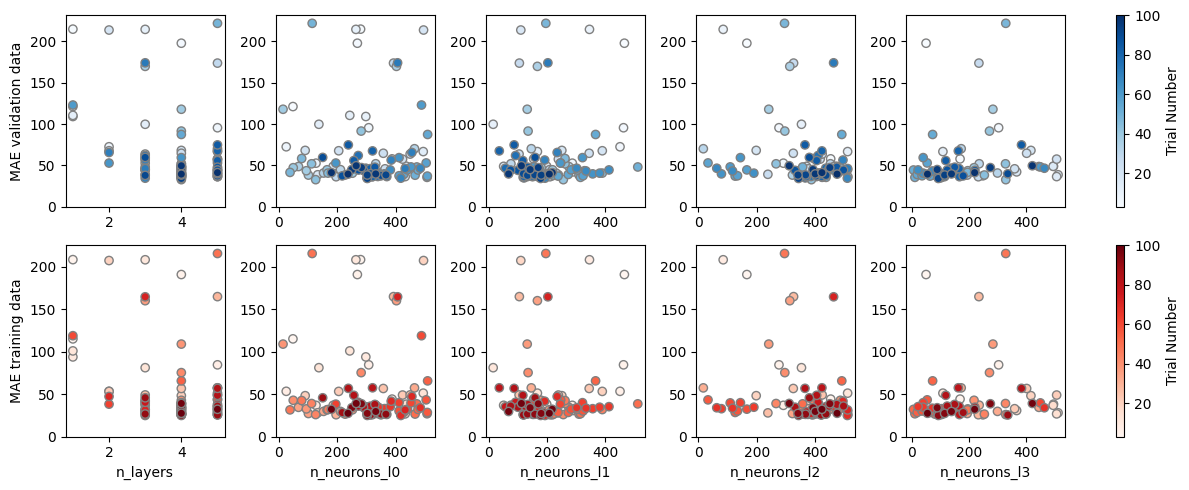

In [ ]:
df = pd.read_csv(f'{path_to_save}{model_name}_opt_his.csv')
NN_architecture = ['n_layers', 'n_neurons_l0', 'n_neurons_l1', 'n_neurons_l2', 'n_neurons_l3', 'n_neurons_l4']
df_a = df[NN_architecture]
df_a
to_append = ['trial_number', 'MAE_val',	'MAE_train', 'Best_MAE_val', 'Best_MAE_train']
df_b = df[to_append]
df_c = pd.concat([df_a, df_b], axis=1)
df= df_c

# Choose a blue colormap for the first row
cmap_n_blue = plt.get_cmap('Blues')

# Choose a red colormap for the second row
cmap_n_red = plt.get_cmap('Reds')

# Adjust the figsize here (width, height) in inches for better visibility
figsize_width = 12  # Adjust based on your actual number of columns and desired figure size
figsize_height = 5  # Height for 2 rows

# Create a figure to hold the subplots with the new figsize
fig = plt.figure(figsize=(figsize_width, figsize_height))

# GridSpec layout with space for colorbars
gs = fig.add_gridspec(2, 6, width_ratios=[1, 1, 1, 1, 1, 0.05], height_ratios=[1, 1])

# Creating subplots for each data plot
axs_data = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(5)]
# Creating subplots for colorbars
axs_cbar = [fig.add_subplot(gs[i, -1]) for i in range(2)]

# Plot each hyperparameter against MAE_val in the first row using the blue colormap
for i, col in enumerate(df.columns[:-5]):  # Adjust based on how many columns you want to plot
    if i < 5:  # Plot in the first 5 subplots of the first row
        sc_blue = axs_data[i].scatter(df[col], df['MAE_val'], c=df['trial_number'], cmap=cmap_n_blue, edgecolor='grey')
        #axs_data[i].set_xlabel(col)
        if i == 0:
            axs_data[i].set_ylabel('MAE validation data')
        axs_data[i].set_ylim(0)

# Plot each hyperparameter against MAE_train in the second row using the red colormap
for i, col in enumerate(df.columns[:-5]):  # Adjust based on how many columns you want to plot
    if i < 5:  # Plot in the first 5 subplots of the second row
        sc_red = axs_data[5 + i].scatter(df[col], df['MAE_train'], c=df['trial_number'], cmap=cmap_n_red, edgecolor='grey')
        axs_data[5 + i].set_xlabel(col)
        if i == 0:
            axs_data[5 + i].set_ylabel('MAE training data')
        axs_data[5 + i].set_ylim(0)

# Add a vertical colorbar to the last column of the first row
fig.colorbar(sc_blue, cax=axs_cbar[0], orientation='vertical').set_label('Trial Number')

# Add a vertical colorbar to the last column of the second row
fig.colorbar(sc_red, cax=axs_cbar[1], orientation='vertical').set_label('Trial Number')

# Dynamically hide unused cells for each row based on actual usage
num_cols = len(df.columns[:-5])  # Number of columns to plot, excluding the last 5
plots_per_row = 5  # Maximum number of plots per row

# Hide unused subplots in the first row if there are less than 5 columns to plot
if num_cols < plots_per_row:
    for i in range(num_cols, plots_per_row):
        axs_data[i].set_visible(False)
        axs_data[5 + i].set_visible(False)

plt.tight_layout()
plt.show()

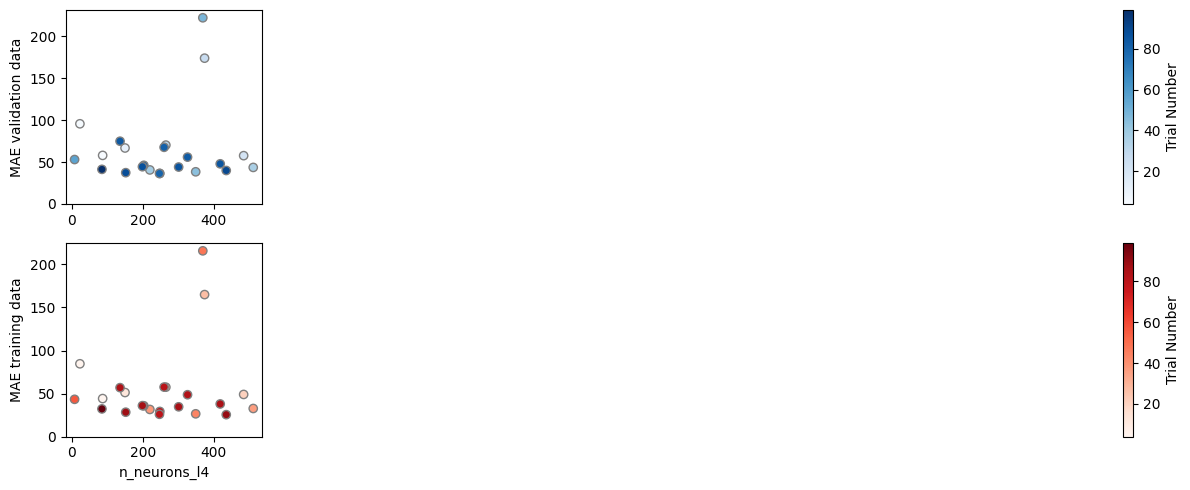

In [ ]:
df = pd.read_csv(f'{path_to_save}{model_name}_opt_his.csv')
NN_architecture = ['n_layers', 'n_neurons_l0', 'n_neurons_l1', 'n_neurons_l2', 'n_neurons_l3', 'n_neurons_l4']
df_a = df[NN_architecture]
df_a
to_append = ['trial_number', 'MAE_val',	'MAE_train', 'Best_MAE_val', 'Best_MAE_train']
df_b = df[to_append]
df_c = pd.concat([df_a, df_b], axis=1)
df= df_c
df = df.iloc[:, 5:]

# Choose a blue colormap for the first row
cmap_n_blue = plt.get_cmap('Blues')

# Choose a red colormap for the second row
cmap_n_red = plt.get_cmap('Reds')

# Adjust the figsize here (width, height) in inches for better visibility
figsize_width = 12  # Adjust based on your actual number of columns and desired figure size
figsize_height = 5  # Height for 2 rows

# Create a figure to hold the subplots with the new figsize
fig = plt.figure(figsize=(figsize_width, figsize_height))

# GridSpec layout with space for colorbars
gs = fig.add_gridspec(2, 6, width_ratios=[1, 1, 1, 1, 1, 0.05], height_ratios=[1, 1])

# Creating subplots for each data plot
axs_data = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(5)]
# Creating subplots for colorbars
axs_cbar = [fig.add_subplot(gs[i, -1]) for i in range(2)]

# Plot each hyperparameter against MAE_val in the first row using the blue colormap
for i, col in enumerate(df.columns[:-5]):  # Adjust based on how many columns you want to plot
    if i < 5:  # Plot in the first 5 subplots of the first row
        sc_blue = axs_data[i].scatter(df[col], df['MAE_val'], c=df['trial_number'], cmap=cmap_n_blue, edgecolor='grey')
        #axs_data[i].set_xlabel(col)
        if i == 0:
            axs_data[i].set_ylabel('MAE validation data')
        axs_data[i].set_ylim(0)

# Plot each hyperparameter against MAE_train in the second row using the red colormap
for i, col in enumerate(df.columns[:-5]):  # Adjust based on how many columns you want to plot
    if i < 5:  # Plot in the first 5 subplots of the second row
        sc_red = axs_data[5 + i].scatter(df[col], df['MAE_train'], c=df['trial_number'], cmap=cmap_n_red, edgecolor='grey')
        axs_data[5 + i].set_xlabel(col)
        if i == 0:
            axs_data[5 + i].set_ylabel('MAE training data')
        axs_data[5 + i].set_ylim(0)

# Add a vertical colorbar to the last column of the first row
fig.colorbar(sc_blue, cax=axs_cbar[0], orientation='vertical').set_label('Trial Number')

# Add a vertical colorbar to the last column of the second row
fig.colorbar(sc_red, cax=axs_cbar[1], orientation='vertical').set_label('Trial Number')

# Dynamically hide unused cells for each row based on actual usage
num_cols = len(df.columns[:-5])  # Number of columns to plot, excluding the last 5
plots_per_row = 5  # Maximum number of plots per row

# Hide unused subplots in the first row if there are less than 5 columns to plot
if num_cols < plots_per_row:
    for i in range(num_cols, plots_per_row):
        axs_data[i].set_visible(False)
        axs_data[5 + i].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
#Train and Evaluate the Final Model
def create_model(best_params):
    model = Sequential()
    n_layers = best_params['n_layers']
    for i in range(n_layers):
        num_neurons = best_params[f'n_neurons_l{i}']
        if i == 0:
            model.add(Dense(num_neurons, activation='relu', input_shape=(X_train_scaled_MnMx.shape[1],)))
        else:
            model.add(Dense(num_neurons))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(best_params['dropout_rate']))
    model.add(Dense(1, kernel_regularizer=L1L2(l1=best_params['l1_reg'], l2=best_params['l2_reg']))) # Adding L1 and L2 regularization to the output layer
    model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mean_absolute_error')
    return model

In [ ]:
best_params = study.best_params
model= create_model(best_params)
print(study.best_params)

{'batch_size': 156, 'epochs': 200, 'n_layers': 4, 'dropout_rate': 0.1, 'l1_reg': 1.9515128674247803e-05, 'l2_reg': 0.019658915895113326, 'n_neurons_l0': 126, 'n_neurons_l1': 256, 'n_neurons_l2': 387, 'n_neurons_l3': 329, 'learning_rate': 0.0016523078379859092}


In [ ]:
model.summary()

Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_480 (Dense)           (None, 126)               3150      
                                                                 
 batch_normalization_380 (B  (None, 126)               504       
 atchNormalization)                                              
                                                                 
 activation_380 (Activation  (None, 126)               0         
 )                                                               
                                                                 
 dropout_380 (Dropout)       (None, 126)               0         
                                                                 
 dense_481 (Dense)           (None, 256)               32512     
                                                                 
 batch_normalization_381 (B  (None, 256)            

In [ ]:
# Set batch_size and epochs
print(model_name)
layers_n = best_params.get('n_layers')
print(f'Layers:{layers_n}')
batch_size_n = best_params.get('batch_size')
print(f'Batch_size:{batch_size_n}')
epochs_n = best_params.get('epochs')
print(f'Epochs:{epochs_n}')
learning_rate_n = best_params.get('learning_rate')
print(f'Learning_rate:{learning_rate_n}')
dropout_rate_n = best_params.get('dropout_rate')
print(f'Dropout_rate:{dropout_rate_n}')

NN_ADV_09_V500K_V2
Layers:4
Batch_size:156
Epochs:200
Learning_rate:0.0016523078379859092
Dropout_rate:0.1


In [ ]:
# Fit the model with scaled target
model.fit(X_train_scaled_MnMx, y_train, batch_size=batch_size_n, epochs=epochs_n, verbose=0)

In [ ]:
model.save(f'{path_to_save}{model_name}_epochs_{epochs_n}', save_format='tf')

In [ ]:
model_name

'NN_ADV_09_V500K_V2'

In [ ]:
epochs_n = 200

In [ ]:
# Load the model from the file
loaded_model = load_model(f'{path_to_save}{model_name}_epochs_{epochs_n}')

In [ ]:
def pred_plot_val(model, X_val_scaled_MnMx, X_train_scaled_MnMx,
              y_val, y_train, y_axis_label, x_axis_label, model_name, epochs_n,
              path_to_save):
    model_predict = model
    # Predict on the transformed and scaled test and train sets
    pred_val_scaled = model_predict.predict(X_val_scaled_MnMx)
    pred_train_scaled = model_predict.predict(X_train_scaled_MnMx)
    # Convert the original y_test and y_train to numpy arrays if they are not already
    array_y_val = np.array(y_val)
    array_y_train = np.array(y_train)
    # Create df_pred_test with inversely transformed predictions
    df_pred_val = pd.DataFrame(data=pred_val_scaled, columns=["pred_val"])
    df_pred_val['y_val'] = pd.DataFrame(data=array_y_val)
    df_pred_val['residual'] = df_pred_val['y_val'] - df_pred_val['pred_val']
    # Create df_pred_train with inversely transformed predictions
    df_pred_train = pd.DataFrame(data=pred_train_scaled, columns=["pred_train"])
    df_pred_train['y_train'] = pd.DataFrame(data=array_y_train)
    df_pred_train['residual'] = df_pred_train['y_train'] - df_pred_train['pred_train']
    # calculate R-squared value
    r2_val = r2_score(df_pred_val['y_val'], df_pred_val['pred_val'])
    r2_train = r2_score(df_pred_train['y_train'], df_pred_train['pred_train'])
    # Calculate RMS error
    MSE_val = mean_squared_error(df_pred_val['y_val'], df_pred_val['pred_val'])
    RMSE_val = np.sqrt(MSE_val)
    MSE_train = mean_squared_error(df_pred_train['y_train'], df_pred_train['pred_train'])
    RMSE_train = np.sqrt(MSE_train)
    MAE_val = mean_absolute_error(df_pred_val['y_val'], df_pred_val['pred_val'])
    MAE_train = mean_absolute_error(df_pred_train['y_train'], df_pred_train['pred_train'])
    # create figure and set size
    fig, ax = plt.subplots(figsize=(6, 5))
    # create scatter plot
    sns.scatterplot( x=df_pred_val['y_val'], y=df_pred_val['pred_val'],color='orange')
    sns.set_style("ticks")
    # add x and y axis labels
    ax.grid(False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    # add R-squared and RMSE  to plot
    ax.text(0.05, 0.9, f'R-squared validation = {r2_val:.4f}', transform=ax.transAxes)
    ax.text(0.05, 0.86, f'R-squared train = {r2_train:.4f}', transform=ax.transAxes)
    ax.text(0.05, 0.82, f'RMSE validation = {RMSE_val:.4f}', transform=ax.transAxes)
    ax.text(0.05, 0.78, f'RMSE train = {RMSE_train:.4f}', transform=ax.transAxes)
    ax.text(0.05, 0.74, f'MAE validation = {MAE_val:.4f}', transform=ax.transAxes)
    ax.text(0.05, 0.70, f'MAE train = {MAE_train:.4f}', transform=ax.transAxes)
    if epochs_n > 0:
        # Add model name to plot title
        ax.set_title(f'Predicted vs. Actual SAR W/g MNP values\n{model_name}\n epochs = {epochs_n}')
        # add the line with separated dots
        plt.plot([df_pred_val['y_val'].min(), df_pred_val['y_val'].max()], [df_pred_val['y_val'].min(), df_pred_val['y_val'].max()], color='black', linestyle='dotted')
        plt.tight_layout()
        plt.savefig(f'{path_to_save}{model_name}_epochs_{epochs_n}_val_pred.png', dpi=300)
    else:
        # Add model name to plot title
        ax.set_title(f'Predicted vs. Actual SAR W/g MNP values\n{model_name}')
        # add the line with separated dots
        plt.plot([df_pred_val['y_val'].min(), df_pred_val['y_val'].max()], [df_pred_val['y_val'].min(), df_pred_val['y_val'].max()], color='black', linestyle='dotted')
        plt.tight_layout()
        plt.savefig(f'{path_to_save}{model_name}_val_pred.png', dpi=300)
    #print results
    print(f'{r2_val:.4f},')
    print(f'{r2_train:.4f},')
    print(f'{RMSE_val:.4f},')
    print(f'{RMSE_train:.4f},')
    print(f'{MAE_val:.4f},')
    print(f'{MAE_train:.4f},')
    print(df_pred_val['residual'].std().__round__(4))


In [ ]:
y_axis_label = 'Predicted SAR (W/g MNP)'
x_axis_label = 'Measured SAR (W/g MNP)'
path_to_save = path_to_save
model = loaded_model

51/51 [==============================] - 0s 2ms/step
0.9328,
0.9630,
85.6041,
60.0315,
39.7478,
26.9314,
85.7429


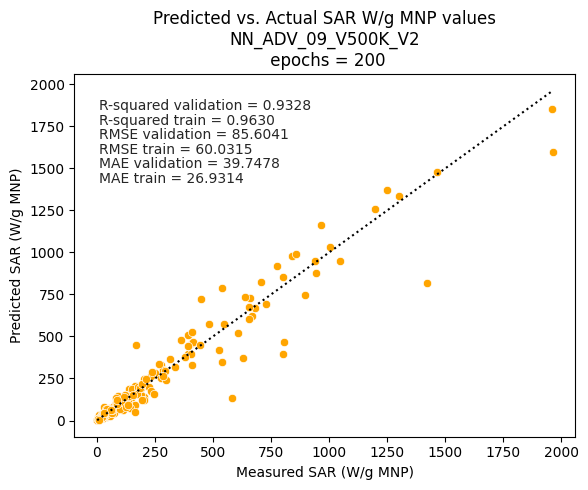

In [ ]:
pred_plot_val(model, X_val_scaled_MnMx, X_train_scaled_MnMx,
              y_val, y_train, y_axis_label, x_axis_label, model_name, epochs_n,
              path_to_save)

In [ ]:
# inspect the model weights
model = loaded_model
weights_data = []

# Loop through each layer
for layer in model.layers:
    weights = layer.get_weights()  # This returns a list of numpy arrays
    if len(weights) > 0:
        # Assuming the first element of weights is the weight matrix (for the weights) and the second is the bias vector
        # The number of nodes can be inferred from the shape of the bias vector
        num_nodes = weights[1].shape[0] if len(weights) > 1 else None  # Assuming bias exists and its shape indicates the number of nodes
        weights_data.append({
            'Layer': layer.name,
            'Parameter': 'Weights',
            'NumNodes': num_nodes,
            'Values': weights[0]
        })
        if len(weights) > 1:
            weights_data.append({
                'Layer': layer.name,
                'Parameter': 'Biases',
                'NumNodes': num_nodes,
                'Values': weights[1],
            })

# Convert the list of dictionaries to a pandas DataFrame
df_weights = pd.DataFrame(weights_data)
df_weights

,Layer,Parameter,NumNodes,Values
0,dense_480,Weights,126,"[[-0.49128234, 0.21233054, -0.05011779, -0.260..."
1,dense_480,Biases,126,"[-0.09408664, 0.045130342, -0.053651664, -0.11..."
2,batch_normalization_380,Weights,126,"[1.2563949, 0.83576065, 0.95328, 1.0761167, 1...."
3,batch_normalization_380,Biases,126,"[-0.08662437, -0.2250733, -0.16875766, 0.08461..."
4,dense_481,Weights,256,"[[0.18757151, 0.09063938, 0.05034944, 0.089252..."
5,dense_481,Biases,256,"[0.0054159206, -0.023559786, 0.023432145, -0.0..."
6,batch_normalization_381,Weights,256,"[0.9605065, 1.0117815, 0.9791161, 0.9231126, 1..."
7,batch_normalization_381,Biases,256,"[-0.19613157, -0.18898122, -0.11918227, -0.330..."
8,dense_482,Weights,387,"[[-0.00053837645, 0.040739395, 0.0051004034, 0..."
9,dense_482,Biases,387,"[0.004946641, -0.0004726833, 0.003287175, 0.00..."


In [ ]:
# reinitialize the model weights
model = loaded_model

# Iterate over the layers of the model
for layer in model.layers:

    # Reinitialize kernel (weight) if the layer has it
    if hasattr(layer, 'kernel_initializer') and any('kernel' in w.name for w in layer.weights):
        # Find the kernel variable
        kernel_var = [var for var in layer.weights if 'kernel' in var.name or 'weight' in var.name][0]
        # Reinitialize the kernel using its initializer
        new_kernel = layer.kernel_initializer(shape=kernel_var.shape, dtype=kernel_var.dtype)
        kernel_var.assign(new_kernel)

    # Set biases to 0 if the layer has biases
    if hasattr(layer, 'bias_initializer') and any('bias' in w.name for w in layer.weights):
        # Find the bias variable
        bias_var = [var for var in layer.weights if 'bias' in var.name][0]
        # Set biases to zeros
        new_bias = tf.zeros(shape=bias_var.shape, dtype=bias_var.dtype)
        bias_var.assign(new_bias)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
# To see if the reinitializing step was correctly performed.
# remember that the initial weights are assigned randomly at the beginning
model = loaded_model
weights_data = []

# Loop through each layer
for layer in model.layers:
    weights = layer.get_weights()  # This returns a list of numpy arrays
    if len(weights) > 0:
        # Assuming the first element of weights is the weight matrix (for the weights) and the second is the bias vector
        num_nodes = weights[1].shape[0] if len(weights) > 1 else None  # Assuming bias exists and its shape indicates the number of nodes
        weights_data.append({
            'Layer': layer.name,
            'Parameter': 'Weights',
            'NumNodes': num_nodes,
            'Values': weights[0]
        })
        if len(weights) > 1:
            weights_data.append({
                'Layer': layer.name,
                'Parameter': 'Biases',
                'NumNodes': num_nodes,
                'Values': weights[1],
            })

# Convert the list of dictionaries to a pandas DataFrame
df_weights = pd.DataFrame(weights_data)
df_weights

,Layer,Parameter,NumNodes,Values
0,dense_480,Weights,126,"[[0.13904066, -0.09678473, -0.029713914, 0.040..."
1,dense_480,Biases,126,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,batch_normalization_380,Weights,126,"[1.2563949, 0.83576065, 0.95328, 1.0761167, 1...."
3,batch_normalization_380,Biases,126,"[-0.08662437, -0.2250733, -0.16875766, 0.08461..."
4,dense_481,Weights,256,"[[0.09997754, -0.026236996, 0.110099524, -0.08..."
5,dense_481,Biases,256,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,batch_normalization_381,Weights,256,"[0.9605065, 1.0117815, 0.9791161, 0.9231126, 1..."
7,batch_normalization_381,Biases,256,"[-0.19613157, -0.18898122, -0.11918227, -0.330..."
8,dense_482,Weights,387,"[[-0.0017639324, -0.0063672736, 0.090720326, 0..."
9,dense_482,Biases,387,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
# creating a learning curve : Loss(MAE) vs epochs
batch_size_n =156
model.fit(x=X_train_scaled_MnMx,y=y_train.values,
          validation_data=(X_val_scaled_MnMx,y_val.values),
          batch_size=batch_size_n,epochs=10000, verbose=1)

Streaming output truncated to the last 5000 lines.
11/11 [==============================] - 0s 9ms/step - loss: 15.1232 - val_loss: 23.6676
Epoch 7502/10000
11/11 [==============================] - 0s 8ms/step - loss: 15.5702 - val_loss: 22.2887
Epoch 7503/10000
11/11 [==============================] - 0s 8ms/step - loss: 14.3846 - val_loss: 24.5215
Epoch 7504/10000
11/11 [==============================] - 0s 9ms/step - loss: 15.3352 - val_loss: 26.4626
Epoch 7505/10000
11/11 [==============================] - 0s 8ms/step - loss: 14.6007 - val_loss: 24.4211
Epoch 7506/10000
11/11 [==============================] - 0s 9ms/step - loss: 13.8810 - val_loss: 22.1303
Epoch 7507/10000
11/11 [==============================] - 0s 9ms/step - loss: 14.0432 - val_loss: 25.0594
Epoch 7508/10000
11/11 [==============================] - 0s 9ms/step - loss: 15.2101 - val_loss: 24.5731
Epoch 7509/10000
11/11 [==============================] - 0s 8ms/step - loss: 14.2333 - val_loss: 25.9378
Epoch 7510/1

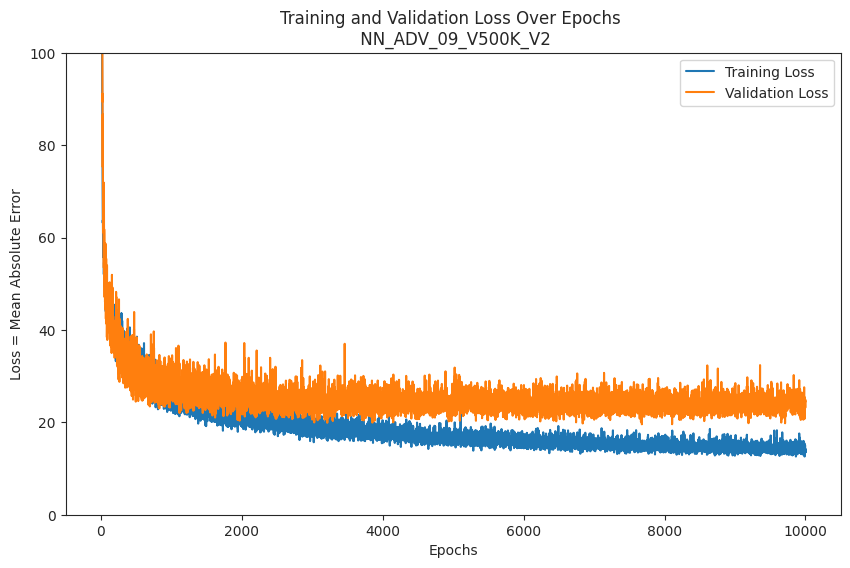

In [ ]:
losses = pd.DataFrame(model.history.history)
plt.figure(figsize=(10, 6))
plt.plot(losses['loss'], label='Training Loss')
plt.plot(losses['val_loss'], label='Validation Loss')
plt.title(f'Training and Validation Loss Over Epochs \n {model_name}')
plt.xlabel('Epochs')
plt.ylabel('Loss = Mean Absolute Error')
plt.ylim(0,100)
plt.legend()
plt.savefig(f'{path_to_save}{model_name}_loss_epochs.png', dpi=300)

In [ ]:
y_axis_label = 'Predicted SAR (W/g MNP)'
x_axis_label = 'Measured SAR (W/g MNP)'
path_to_save = path_to_save
model = model
epochs_n = 10000

51/51 [==============================] - 0s 2ms/step
0.9686,
0.9980,
58.5729,
13.7979,
23.8761,
7.4257,
58.6832


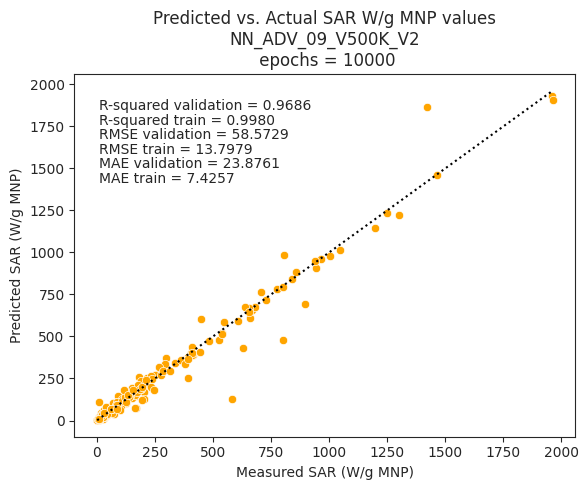

In [ ]:
pred_plot_val(model, X_val_scaled_MnMx, X_train_scaled_MnMx,
              y_val, y_train, y_axis_label, x_axis_label, model_name, epochs_n,
              path_to_save)